In [11]:
import sys, os

sys.path.append(os.path.abspath(os.path.join("../")))

import pandas as pd
import numpy as np
import glob
import statsmodels.formula.api as smf
import datetime as dt
from tqdm.auto import tqdm

# Main

In [12]:
# Params
year_range = range(1996,2021)
sample_freq = '15min'

In [15]:
for year in tqdm(year_range):

    ## Load in TAQ Prices
    taq_data_df = pd.read_parquet(
        glob.glob(f"../../../../GitHub/High-Freq-ML/data/taq/prices/{year}*.parquet")
    )

    # Add datetime
    taq_data_df["datetime"] = pd.to_datetime(
        taq_data_df["date"].astype(str) + " " + taq_data_df["time"]
    )
    
    # Fix missing permno
    taq_data_df['permno'] = taq_data_df['permno'].astype(str)
    taq_data_df.loc[taq_data_df['symbol'] == 'QQQ', 'permno'] = 86755
    
    # Fix mislabelled symbol
    taq_data_df['symbol'] = taq_data_df['symbol'].astype(str)
    taq_data_df.loc[taq_data_df['symbol'] == 'QQQQ', 'symbol'] = 'QQQ'

    # Construct unique identifier
    taq_data_df["identifier"] = (
        "permno__"
        + taq_data_df["permno"].astype(str)
        + "__symbol__"
        + taq_data_df["symbol"].astype(str).str.replace('.', '')
    )

    ## Clean prices
    
    # Drop duplicated by picking the one with a defined cusip
    taq_data_df = taq_data_df.sort_values(by = 'cusip8')
    taq_data_df = taq_data_df.drop_duplicates(subset = ['datetime', 'identifier'], keep = 'last')
    
    # Get pivotted [sample_frequency] prices
    pivot_data_df = taq_data_df.pivot(index="datetime", values="price", columns="identifier")
    pivot_data_df = pivot_data_df.resample(sample_freq, closed="right", label="right").last().ffill()
    
    # Filter to days with trading
    trading_dates = pd.to_datetime(taq_data_df["date"].unique(), format="%Y%m%d")
    pivot_data_df = pivot_data_df.loc[pivot_data_df.index.strftime('%Y-%m-%d').isin(trading_dates.strftime('%Y-%m-%d'))]
    
    # Get log returns
    pivot_data_df = pivot_data_df.apply(np.log) - pivot_data_df.apply(np.log).shift(
            1
        )

    # Set first return in the data to zero
    pivot_data_df.iloc[0,:] = 0
    
    # Adjust column names
    pivot_data_df.columns = pivot_data_df.columns.astype(str)
    pivot_data_df.columns.name = None
    
    # This should have no effect, just filters to intradaily observations
    pivot_data_df = pivot_data_df.loc[
        (pivot_data_df.index.time >= dt.time(9, 30)) & (pivot_data_df.index.time <= dt.time(16, 0))
    ].sort_index()
    
    ## Fix various errors?
    if year == '2015':
        # Fix VV error
        pivot_data_df.loc['2015-08-24 09:45:00', 'permno__90002__symbol__VV'] = np.nan
        pivot_data_df.loc['2015-08-24 10:00:00', 'permno__90002__symbol__VV'] = np.nan

    ## Save
    pivot_data_df.to_parquet(f"../../data/taq/clean_prices/{year}.parquet")

  0%|          | 0/25 [00:00<?, ?it/s]

/tmp/ipykernel_27416/2860629971.py:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  + taq_data_df["symbol"].astype(str).str.replace('.', '')


# Check

## Output

In [40]:
pd.read_parquet(
        glob.glob(f"../../../../GitHub/High-Freq-ML/data/taq/prices/{2004}*.parquet")
    ).groupby(['ticker_identifier']).first()

,cusip8,date,permno,price,symbol,time
ticker_identifier,,,,,,
84398_78462F10_SPY,78462F10,20040102,84398,111.760,SPY,10:00:00
86755_63110010_QQQ,63110010,20040102,86755,36.660,QQQ,10:00:00
88215_46428720_IVV,46428720,20040102,88215,111.830,IVV,10:00:00
88222_46428765_IWM,46428765,20040102,88222,111.940,IWM,10:00:00
90002_92290863_VV,92290863,20040130,90002,49.400,VV,10:00:00
90004_92290874_VTV,92290874,20040130,90004,49.310,VTV,10:00:00
90005_92290875_VB,92290875,20040130,90005,48.800,VB,10:00:00
._63110010_QQQ,63110010,20041130,,39.265,QQQ,10:00:00
86755_63110010_QQQQ,63110010,20041201,86755,39.470,QQQQ,10:00:00


In [53]:
pd.read_parquet('../../data/taq/clean_prices/2014.parquet').head()

,permno__12305__symbol__VOO,permno__12313__symbol__VONE,permno__84144__symbol__VONE,permno__84398__symbol__SPY,permno__86379__symbol__VOO,permno__86755__symbol__QQQ,permno__88215__symbol__IVV,permno__88222__symbol__IWM,permno__90002__symbol__VV,permno__90004__symbol__VTV,permno__90005__symbol__VB,permno__91010__symbol__ONEK,permno__93269__symbol__TQQQ
datetime,,,,,,,,,,,,,
2014-01-02 09:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2014-01-02 09:45:00,-0.002317,-0.000118,-0.000118,-0.001959,-0.002317,-0.003203,-0.002029,-0.006188,-0.002724,-0.002104,-0.005304,0.0,-0.009109
2014-01-02 10:00:00,0.000416,0.000118,0.000118,0.000000,0.000416,-0.001032,0.000027,0.000350,0.000474,0.000790,0.002015,0.0,-0.003138
2014-01-02 10:15:00,-0.000535,0.000000,0.000000,-0.000272,-0.000535,0.001032,-0.000271,0.001310,-0.000593,-0.000790,0.001828,0.0,0.003055
2014-01-02 10:30:00,-0.000119,0.000000,0.000000,-0.000327,-0.000119,-0.001032,-0.000379,-0.000524,-0.000119,-0.000527,-0.000914,0.0,-0.003945


## Aggregated

In [60]:
import matplotlib.pyplot as plt

In [61]:
# Load data
fret_df = pd.concat(
    [
        pd.read_parquet(x)
        for x in glob.glob("../../data/taq/clean_prices/*.parquet")
    ]
)

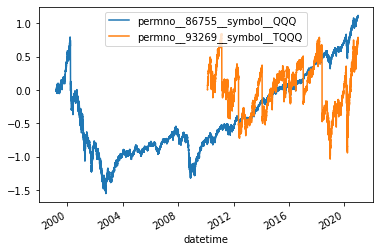

In [62]:
fret_df[[x for x in fret_df.columns if 'QQQ' in x]].cumsum().plot()
plt.legend()

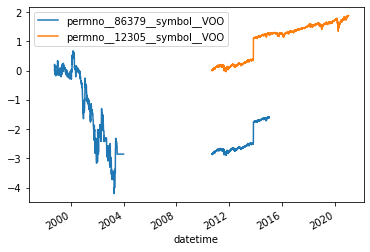

In [63]:
fret_df[[x for x in fret_df.columns if 'VOO' in x]].cumsum().plot()
plt.legend()

# Check MKT

In [2]:
from helper_libraries import results_tools
import statsmodels.formula.api as smf

In [3]:
# Load SPY returns
fret_df, _ = results_tools.load_mkt_rf_returns()

In [4]:
# Load FF-MKT returns
fret2_df, _ = results_tools.load_mkt_rf_returns(use_spy_etf=False)

In [5]:
# Load CRSP Mkt Excess returns
fret3_df = pd.read_excel('../../data/dlrz/dataMarketRx.xlsx')
fret3_df['date'] = pd.to_datetime(fret3_df['date'], format = '%Y%m%d')
fret3_df = fret3_df.set_index('date')

In [6]:
# Load FF factors
fret4_df = pd.read_csv('../../data/ff/F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows = 3)
fret4_df['date'] = pd.to_datetime(fret4_df['Unnamed: 0'], format = "%Y%m%d")
fret4_df = fret4_df.set_index('date')

### Reg SPY with FF MKT

In [7]:
# Combine
concat_df = pd.concat([fret2_df, fret_df], axis=1).groupby(pd.Grouper(freq = '15min')).sum()

In [8]:
# Regression
smf.ols('ff__mkt ~ market_return', concat_df.loc[concat_df.index.time != dt.time(9,30)].dropna()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ff__mkt   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 8.299e+06
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        09:55:10   Log-Likelihood:             6.0057e+06
No. Observations:              867376   AIC:                        -1.201e+07
Df Residuals:                  867374   BIC:                        -1.201e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.149e-07   2.56e-07      2.405      0.016    1.14e-07    1.12e-06
market_return     0.8750      0.000   2880.854      0.000       0.874       0.876
==============================================================================
Omnibus:                   532607.050   Durbin-Watson:                   2.488
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1674301784.071
Skew:                          -1.284   Prob(JB):                         0.00
Kurtosis:                     218.223   Cond. No.                     1.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
# Regression
smf.ols('ff__mkt ~ market_return', concat_df.loc[concat_df.index.time != dt.time(9,30)].dropna().groupby(pd.Grouper(freq = '1d')).sum()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ff__mkt   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                 2.394e+05
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        09:55:18   Log-Likelihood:                 45949.
No. Observations:                9131   AIC:                        -9.189e+04
Df Residuals:                    9129   BIC:                        -9.188e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.173e-05   1.65e-05      3.736      0.000    2.93e-05    9.41e-05
market_return     0.9748      0.002    489.294      0.000       0.971       0.979
==============================================================================
Omnibus:                     6233.828   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1049451.643
Skew:                          -2.305   Prob(JB):                         0.00
Kurtosis:                      55.318   Cond. No.                         121.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
concat_df['ff__mkt_lag'] = concat_df['ff__mkt'].shift(1)
for year in range(1996,2021):
    fit = smf.ols('market_return ~ ff__mkt', concat_df.loc[concat_df.index.time != dt.time(9,30)].loc[str(year)].dropna()).fit()
    print(year, fit.rsquared)

1996 0.6059512042534616
1997 0.7399239704514107
1998 0.8040727174920101
1999 0.8108191667611846
2000 0.8307840085337739
2001 0.8578922733428545
2002 0.9365933262316269
2003 0.9418168383183431
2004 0.9267498652684675
2005 0.9411992036955529
2006 0.9504394388966402
2007 0.9637107888853194
2008 0.9734260778733599
2009 0.9762721183662734
2010 0.9771940683299243
2011 0.9821521729563056
2012 0.9709760971005124
2013 0.9662888168699152
2014 0.9667010425506161
2015 0.9723863317368092
2016 0.9727434742551135
2017 0.9533835600463797
2018 0.9819352373477416
2019 0.975714307003375
2020 0.9825337936271632


In [130]:
concat_df['ff__mkt_lag'] = concat_df['ff__mkt'].shift(1)
for year in range(1996,2021):
    fit = smf.ols('market_return ~ ff__mkt', concat_df.loc[concat_df.index.time != dt.time(9,30)].loc[str(year)].groupby(pd.Grouper(freq = '1d')).sum().dropna()).fit()
    print(year, fit.rsquared)

1996 0.8845051130297965
1997 0.9437231554457262
1998 0.9541847964496669
1999 0.9435154394020759
2000 0.9172715797277565
2001 0.913239388461374
2002 0.9849318474542216
2003 0.979130969880079
2004 0.9720095625844901
2005 0.9760322187228767
2006 0.9734933772846635
2007 0.9789792196942224
2008 0.9832133983396829
2009 0.9842216372814544
2010 0.9855963659173773
2011 0.991188170466336
2012 0.9840824486890252
2013 0.979837228658448
2014 0.9790040138843763
2015 0.9804950176939431
2016 0.9787623419131228
2017 0.9606035032079259
2018 0.9885845339439707
2019 0.9816780831694243
2020 0.9801650304771374


### Reg SPY with CRSP MKT

In [93]:
# Combine
concat_df = pd.concat([fret3_df, fret_df.groupby(pd.Grouper(freq = '1m')).sum()], axis=1).dropna()

<AxesSubplot:>

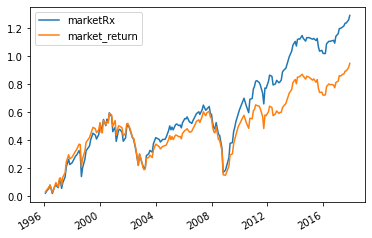

In [94]:
concat_df.cumsum().plot()

In [96]:
# Regression
smf.ols('marketRx ~ market_return', concat_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               marketRx   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     4075.
Date:                Sun, 17 Apr 2022   Prob (F-statistic):          5.26e-127
Time:                        13:16:34   Log-Likelihood:                 603.77
No. Observations:                 185   AIC:                            -1204.
Df Residuals:                     183   BIC:                            -1197.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0017      0.001      2.435      0.016       0.000       0.003
market_return     1.0332      0.016     63.836      0.000       1.001       1.065
==============================================================================
Omnibus:                       15.694   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.450
Skew:                          -0.274   Prob(JB):                     2.71e-09
Kurtosis:                       5.195   Cond. No.                         23.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Reg FF-MKT with CRSP MKT

In [89]:
# Combine
concat_df = pd.concat([fret3_df, fret4_df[['Mkt-RF']].groupby(pd.Grouper(freq = '1m')).sum()/100], axis=1).dropna()

<AxesSubplot:xlabel='date'>

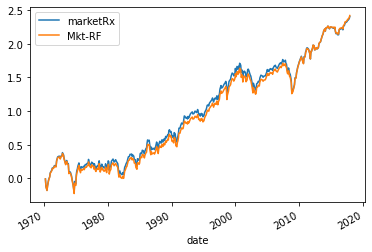

In [91]:
concat_df.cumsum().plot()

In [92]:
# Regression
smf.ols('marketRx ~ Q("Mkt-RF")', concat_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               marketRx   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.611e+05
Date:                Sun, 17 Apr 2022   Prob (F-statistic):               0.00
Time:                        13:16:23   Log-Likelihood:                 1983.3
No. Observations:                 403   AIC:                            -3963.
Df Residuals:                     401   BIC:                            -3955.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6.778e-05   8.89e-05     -0.763      0.446      -0.000       0.000
Q("Mkt-RF")     1.0052      0.002    511.017      0.000       1.001       1.009
==============================================================================
Omnibus:                       94.946   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2760.797
Skew:                           0.078   Prob(JB):                         0.00
Kurtosis:                      15.821   Cond. No.                         22.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""